# Curso de CNN con PyTorch

<img src="https://yaelmanuel.com/wp-content/uploads/2021/12/platzi-banner-logo-matematicas.png" width="500px">

---

## Creando nuestro propio Clasificador de Imágenes 👀😷

En este lab aprenderás:

* [Pytorch](https://pytorch.org/)
* [Torchvision](https://pytorch.org/vision/stable/index.html)
* Descargar un dataset, prepararlo, entrenarlo, realizar finetuning y guardarlo.


### 1) Cargar el dataset 🤓

**Tenemos 2 formas:**

**1)** Cargar el dataset arrastrando el .zip hacia el notebook.

In [16]:
#!unzip "labeled-chest-xray-images.zip"

**2)** Guardar el .zip en Google Drive y luego darle permisos al notebook para que pueda accederlo.

In [17]:
#from google.colab import drive
#drive.mount('/content/drive')

### 2) Preparación de la data 👌

#### 2.1) Instalamos las dependencias 🙌

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

**Agregar nuevas dependencias para las métricas**

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

**Agregar dependencias para GRAD CAM**

In [20]:
import cv2
import torchvision.transforms.functional as TF
from PIL import Image

#### 2.2) Tips de implementación 👀

In [21]:
cudnn.benchmark = True

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 2.3) Data Augmentation 📷 📸

In [23]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#### 2.4) Dataset, Dataloader y más data 🔍

In [24]:
data_dir = '/content/chest_xray'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

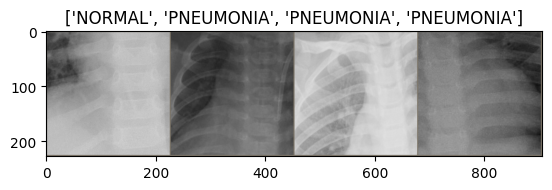

In [25]:
def imshow(inp, title=None):
    """Imshow para tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pausarlo un poco para que se actualicen los plots


# Obtener un batch de datos de entrenamiento
inputs, classes = next(iter(dataloaders['train']))

# Crear una grilla con las imágenes
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

***Evaluar las class_names***

In [26]:
print(class_names)

['NORMAL', 'PNEUMONIA']


### 3) Finetuning de la convnet 😨

#### 3.1) Construir CNN desde Cero

##### CNN 1

**1) Definir capa tras capa de nuestra CNN**

Para este caso es una estructura estrictamente secuencial.

In [27]:
layers = [
    # Bloque conv → ReLU → pool
    nn.Conv2d(3, 4, kernel_size=3, padding=1),    # De 3 canales (RGB) a 4 mapas de características
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                           # Pooling reduce a la mitad la resolución

    # Aplanar y FCs (Capas fully-connected)
    nn.Flatten(),
    nn.Linear(4 * 112 * 112, 2)                   # Asume entrada 224×224 → tras pooling 112×112
]

**2) Montar el Sequential**

In [28]:
model_ft = nn.Sequential(*layers)

model_ft = model_ft.to(device)

##### CNN 2

**1) Definir capa tras capa de nuestra CNN**

Para este caso es una estructura estrictamente secuencial.

In [29]:
layers = [
    # Bloque conv → ReLU → pool
    nn.Conv2d(3, 16, kernel_size=3, padding=1),   # De 3 canales (RGB) a 16 mapas de características
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                           # Reducción: 224x224 -> 112x112

    # Segundo bloque conv → ReLU → pool
    nn.Conv2d(16, 32, kernel_size=3, padding=1),  # 16 -> 32
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                           # 112x112 -> 56x56

    # Aplanar y FCs (Capas fully-connected)
    nn.Flatten(),                                 # (Batch, 32, 56, 56) → (Batch, 32*56*56)
    nn.Linear(32 * 56 * 56, 128),
    nn.ReLU(),
    nn.Linear(128, 2)                             # Salida para 2 clases
]

**2) Montar el Sequential**

In [30]:
model_ft = nn.Sequential(*layers)

model_ft = model_ft.to(device)

#### 3.2) Transfer Learning

In [31]:
from torchvision.models import ResNet50_Weights

In [32]:
model_ft = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


In [33]:
# Aquí el tamaño de cada muestra de salida se establece en len(class_names) = 2.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

### 4) Entrenamiento 💪

**Guardar los valores de las predicciones y sus probabilidades en la validación y entrenamiento**

In [34]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    val_preds, val_labels, val_probs = [], [], []
    train_preds, train_labels, train_probs = [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            preds_epoch, labels_epoch, probs_epoch = [], [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Guardar predicciones para ROC y métricas
                preds_epoch.extend(preds.detach().cpu().numpy())
                labels_epoch.extend(labels.detach().cpu().numpy())
                probs_epoch.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_preds, train_labels, train_probs = preds_epoch, labels_epoch, probs_epoch
            elif phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                val_preds, val_labels, val_probs = preds_epoch, labels_epoch, probs_epoch

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, (train_preds, train_labels, train_probs), (val_preds, val_labels, val_probs)

In [35]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

**Agregar nueva función para visualizar nuevas métricas**

In [36]:
def evaluate_model(train_data, val_data, class_names):
    train_preds, train_labels, train_probs = train_data
    val_preds, val_labels, val_probs = val_data

    print("\nReporte de Clasificación:\n")
    print(classification_report(val_labels, val_preds, target_names=class_names))

    # === Matriz de Confusión: valores absolutos y porcentajes ===
    cm = confusion_matrix(val_labels, val_preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    labels_combined = np.empty_like(cm).astype('object')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            labels_combined[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=labels_combined, fmt='', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Matriz de Confusión (Absoluto + Porcentual)')
    plt.tight_layout()
    plt.show()

    # === ROC Curve (si binario) ===
    if len(class_names) == 2:
        plt.figure()
        for split, labels, probs in [('Train', train_labels, train_probs), ('Validation', val_labels, val_probs)]:
            y_true = np.array(labels)
            y_scores = np.array(probs)[:, 1]

            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve: Train vs Validation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

#### **Definir Función de Loss y Optimizador**

In [37]:
criterion = nn.CrossEntropyLoss()

# Observe que todos los parámetros están siendo optimizados
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decae LR por un factor de 0.1 cada 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

**Ahora el entrenamiento recibe más parámetros**

In [38]:
model_ft, train_data, val_data = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler,
    dataloaders, dataset_sizes, device, num_epochs=5
)

Epoch 0/4
----------
train Loss: 0.3949 Acc: 0.8370
val Loss: 0.2360 Acc: 0.9151

Epoch 1/4
----------
train Loss: 0.2665 Acc: 0.8970
val Loss: 0.3703 Acc: 0.8878

Epoch 2/4
----------
train Loss: 0.2524 Acc: 0.9069
val Loss: 0.2691 Acc: 0.9247

Epoch 3/4
----------
train Loss: 0.2226 Acc: 0.9192
val Loss: 0.2031 Acc: 0.9295

Epoch 4/4
----------
train Loss: 0.1904 Acc: 0.9306
val Loss: 2.7101 Acc: 0.4519

Training complete in 8m 51s
Best val Acc: 0.9295


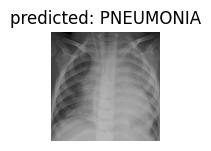

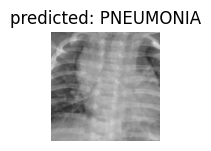

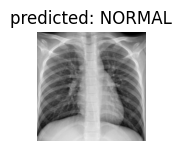

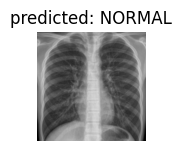

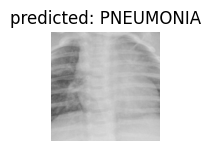

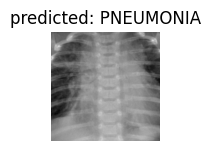

In [39]:
visualize_model(model_ft)

**Conceptos**

- **Accuracy:** Proporción de predicciones correctas sobre el total de predicciones realizadas.

- **Precisión:** Proporción de predicciones positivas correctas sobre todas las predicciones positivas realizadas.​

- **Recall (sensibilidad):** Proporción de verdaderos positivos detectados sobre todos los casos positivos reales.​

- **F1-score:** Media armónica entre precisión y recall; balancea ambos en una sola métrica.​

- **Curva ROC:** Gráfica que muestra la tasa de verdaderos positivos frente a la de falsos positivos a diferentes umbrales.​


Reporte de Clasificación:

              precision    recall  f1-score   support

      NORMAL       0.98      0.83      0.90       234
   PNEUMONIA       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



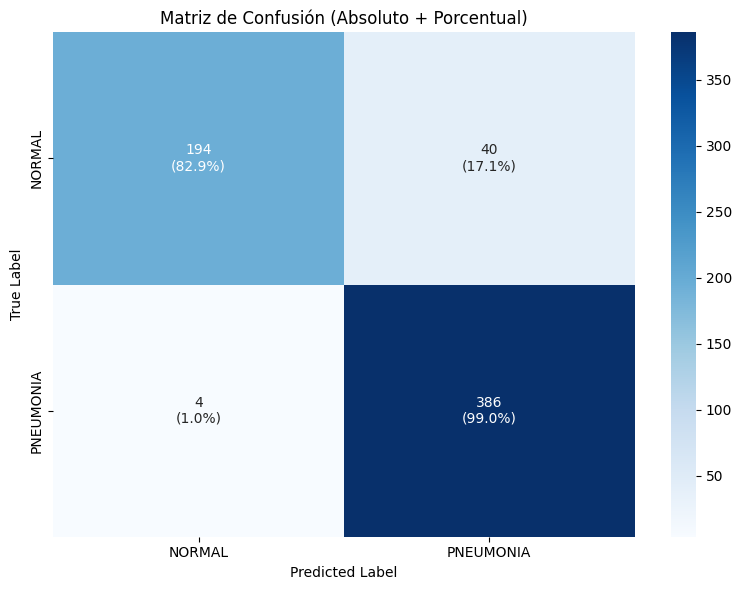

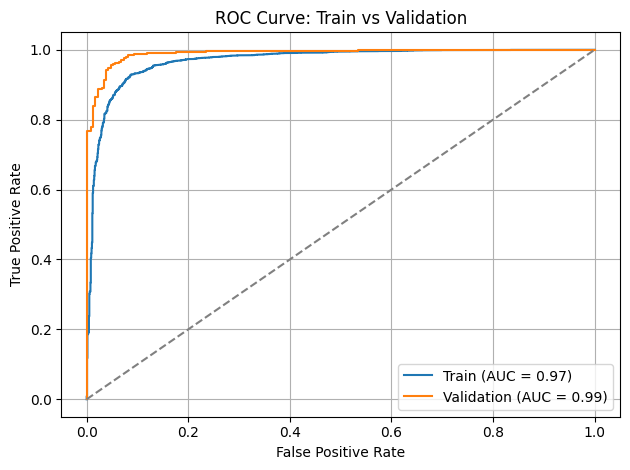

In [40]:
evaluate_model(train_data, val_data, class_names)

### 5) Guardar el modelo 💾

In [41]:
torch.save(model_ft, "model.pth")

### 6) GRAD-CAM 🧐

In [42]:
class GradCAM:
    """
    Grad-CAM para PyTorch, con limpieza de hooks previos.
    Uso:
      gradcam = GradCAM(model, target_layer)
      mask = gradcam(input_tensor, class_idx=None)
    """
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activation = None
        self.gradient = None

        # --- Limpiar cualquier hook registrado previamente ---
        if hasattr(target_layer, '_forward_hooks'):
            target_layer._forward_hooks.clear()
        if hasattr(target_layer, '_backward_hooks'):
            target_layer._backward_hooks.clear()
        if hasattr(target_layer, '_full_backward_hooks'):
            target_layer._full_backward_hooks.clear()

        # --- Definir hooks ---
        def forward_hook(module, input, output):
            self.activation = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradient = grad_output[0].detach()

        # Registrar solo forward + full backward hook
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, input_tensor, class_idx=None):
        # Forward
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward
        self.model.zero_grad()
        one_hot = torch.zeros_like(output, device=output.device)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot)

        # Extraer gradientes y activaciones
        grads = self.gradient[0]    # [C, H, W]
        acts  = self.activation[0]  # [C, H, W]

        # Pesos (global average pooling)
        weights = grads.mean(dim=(1,2))  # [C]

        # Construir mapa de calor en mismo dispositivo
        cam = torch.zeros(acts.shape[1:], device=acts.device)
        for w, a in zip(weights, acts):
            cam += w * a
        cam = torch.relu(cam)

        # Normalizar a [0,1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam.cpu().numpy()

In [57]:
def show_gradcam(input_tensor, mask, title=None):
    """
    Superpone la máscara de Grad-CAM sobre la imagen original.
    - input_tensor: tensor (1,3,H,W) normalizado
    - mask: numpy array HxW en [0,1]
    """
    # Desnormalizar imagen
    img = input_tensor.squeeze().cpu()
    img = TF.normalize(img,
                       [-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
                       [1/s for s in [0.229,0.224,0.225]])
    img = torch.clamp(img, 0, 1)
    img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)

    # Crear heatmap
    heatmap = cv2.resize(mask, (img_np.shape[1], img_np.shape[0]))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superponer heatmap y original
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # Mostrar
    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [58]:
# Función helper para mostrar varias imágenes con Grad-CAM
def run_and_show_gradcam(model, target_layer, dataloader, class_names, device, num_images=5):
    """
    Ejecuta Grad-CAM sobre las primeras `num_images` de la partición 'val' y las muestra.

    Args:
        model: modelo entrenado en modo eval().
        target_layer: módulo Conv2d sobre el cual computar Grad-CAM.
        dataloader: diccionario con dataloaders, usa dataloader['val'].
        class_names: lista de nombres de clase.
        device: 'cuda' o 'cpu'.
        num_images: cuántas imágenes mostrar.
    """
    model.eval()
    gradcam = GradCAM(model, target_layer)
    data_iter = iter(dataloader['val'])
    images_shown = 0

    plt.figure(figsize=(6 * num_images, 6))
    while images_shown < num_images:
        try:
            inputs, labels = next(data_iter)
        except StopIteration:
            break  # si no hay más datos
        for idx in range(inputs.size(0)):
            if images_shown >= num_images:
                break
            inp = inputs[idx].unsqueeze(0).to(device)
            lbl = labels[idx].item()
            mask = gradcam(inp, class_idx=lbl)

            # superponer y mostrar
            plt.subplot(1, num_images, images_shown + 1)
            # reutiliza show_gradcam internamente, pero sin crear nueva figura
            img = inp.squeeze().cpu()
            img = TF.normalize(img,
                               [-m/s for m, s in zip([0.485,0.456,0.406],[0.229,0.224,0.225])],
                               [1/s for s in [0.229,0.224,0.225]])
            img = torch.clamp(img, 0, 1)
            img_np = (img.permute(1,2,0).numpy() * 255).astype(np.uint8)
            heatmap = cv2.resize(mask, (img_np.shape[1], img_np.shape[0]))
            heatmap = (heatmap * 255).astype(np.uint8)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

            plt.imshow(overlay)
            plt.title(f"GT: {class_names[lbl]}")
            plt.axis('off')

            images_shown += 1
    plt.tight_layout()
    plt.show()

**Ejemplo de uso para cada arquitectura**

In [45]:
# 1) CNN 1 (Sequential con 1 conv)
#    layers = [Conv2d, ReLU, MaxPool2d, Flatten, Linear]
#    -> la última capa conv está en index 0
# target_layer_cnn1 = model_ft[0]  # nn.Conv2d(3,4,...)

# 2) CNN 2 (Sequential con 2 convs)
#    layers = [Conv2d, ReLU, MaxPool2d, Conv2d, ReLU, MaxPool2d, Flatten, ...]
#    -> la segunda y más profunda conv está en index 3
# target_layer_cnn2 = model_ft[3]  # nn.Conv2d(16,32,...)

# 3) ResNet50 (pre-entrenada)
#    usamos la última conv del cuarto bloque residual
#    -> model_ft = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
#    -> model_ft.fc = nn.Linear(num_ftrs, len(class_names))
target_layer_resnet50 = model_ft.layer4[-1].conv3

**Ejemplo en validación**

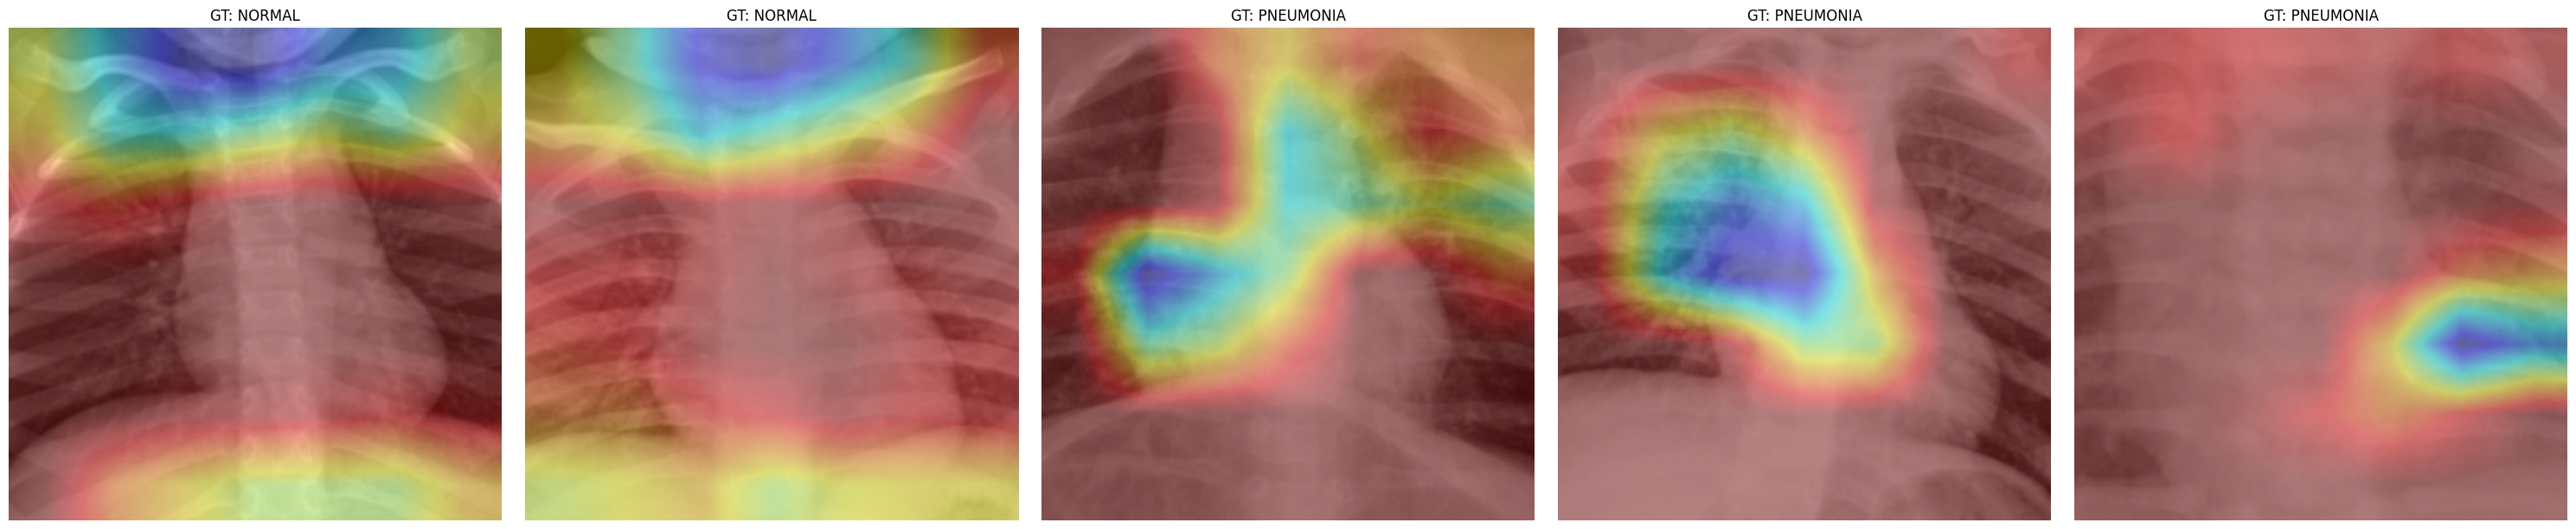

In [60]:
# run_and_show_gradcam(model_ft, target_layer_cnn1, dataloaders, class_names, device, num_images=5)
# run_and_show_gradcam(model_ft, target_layer_cnn2, dataloaders, class_names, device, num_images=5)
run_and_show_gradcam(model_ft, target_layer_resnet50, dataloaders, class_names, device, num_images=5)

**Aplicar GRAD CAM a una imagen en específico**

In [61]:
def gradcam_from_path(model, target_layer, image_path, device, class_names, preprocess=None):
    """
    Carga una imagen desde `image_path`, calcula y devuelve la máscara Grad-CAM.

    Args:
        model: modelo entrenado en modo eval().
        target_layer: capa Conv2d sobre la cual aplicar Grad-CAM.
        image_path (str): ruta al archivo de imagen.
        device: 'cuda' o 'cpu'.
        class_names (list): nombres de las clases para interpretar la predicción.
        preprocess (torchvision.transforms.Compose, opcional): transformaciones a aplicar
            (debe incluir Resize(224), CenterCrop(224), ToTensor(), Normalize(...)).
            Si es None, usa un pipeline por defecto.

    Returns:
        mask (numpy array H×W): máscara Grad-CAM normalizada.
        pred_class (str): nombre de la clase predicha.
    """
    # Pipeline de preprocesamiento por defecto
    if preprocess is None:
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
        ])

    # Cargar y preprocesar la imagen
    image = Image.open(image_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    # Predecir clase
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        pred_idx = outputs.argmax(dim=1).item()
        pred_class = class_names[pred_idx]

    # Calcular Grad-CAM
    gradcam = GradCAM(model, target_layer)
    mask = gradcam(input_tensor, class_idx=pred_idx)

    return mask, pred_class

Clase predicha: PNEUMONIA


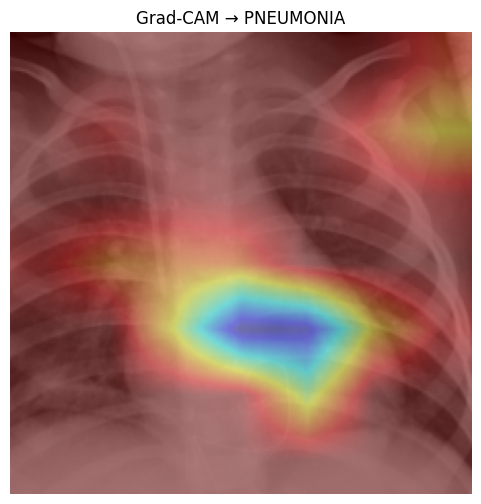

In [63]:
# 1) Definís la ruta de tu imagen
image_path = "/content/bacteria.jpeg"
target_layer = target_layer_resnet50

# 2) Llamás a la función para obtener la máscara y la clase predicha
mask, pred_class = gradcam_from_path(
    model=model_ft,
    target_layer=target_layer,
    image_path=image_path,
    device=device,
    class_names=class_names
)

# 3) Mostrás el Grad-CAM sobre la imagen
print(f"Clase predicha: {pred_class}")
show_gradcam(
    input_tensor=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device),
    mask=mask,
    title=f"Grad-CAM → {pred_class}"
)

### 7) Hacer Predicciones en Producción 🤙

In [49]:
import torch
from torchvision import transforms
from PIL import Image

Cargar el modelo una vez (al inicio de la aplicación)

In [50]:
# Determinar el dispositivo
mi_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo en el dispositivo
mi_modelo = torch.load("model.pth", map_location=mi_device, weights_only=False)
mi_modelo.eval()
mi_modelo.to(mi_device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Función para predicción / inferencia

In [51]:
def predict_image(image_path, model, class_names, device):
    """
    Predice la clase de una imagen usando un modelo entrenado.

    Args:
        image_path (str): Ruta de la imagen.
        model (torch.nn.Module): Modelo ya cargado y configurado para inferencia.
        class_names (list): Lista de nombres de clases.
        device (torch.device): Dispositivo donde está el modelo.

    Returns:
        str: Clase predicha.
    """
    # Preprocesamiento de la imagen
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Cargar y preprocesar la imagen
    image = Image.open(image_path).convert("RGB")
    image_tensor = preprocess(image).unsqueeze(0).to(device)  # Añadir dimensión batch y mover al dispositivo

    # Realizar predicción
    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    # Retornar la clase predicha
    return class_names[preds[0].item()]


Ejemplos de uso

In [52]:
class_names = ['NORMAL', 'PNEUMONIA']

In [53]:
path_image = "/content/chest_xray/val/NORMAL/NORMAL-1049278-0001.jpeg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: NORMAL


In [54]:
path_image = "/content/chest_xray/val/PNEUMONIA/BACTERIA-1135262-0002.jpeg"

predicted_class = predict_image(path_image, mi_modelo, class_names, mi_device)
print(f"La clase predicha es: {predicted_class}")

La clase predicha es: PNEUMONIA


### 8) Conclusiones

- Aprender sobre los distintos objetos y métodos que nos ofrece Pytorch / Torchvision.

- Realizar el proceso completo de clasificación de imágenes con Pytorch.

- Aprender tips sobre implementación con el uso de la GPU.

<br>
<br>
<br>